In [9]:
import pandas as pd

# Load the uploaded CSV file
file_path = "data/ELSI_funding_and_more.csv"
df = pd.read_csv(file_path)

cost_df = pd.read_csv("data/ELSI_cost_per_student.csv")
# Check the column names and preview to determine matching keys and year format
df.shape, cost_df.shape

((8953, 270), (20782, 9))

In [10]:
# Define target states
target_states = {"ARIZONA", "FLORIDA", "HAWAII", "INDIANA"}
# filter by state (some are capitalized, some not)
filtered_df = df[df["State Name [District] Latest available year"].str.upper(
).isin(target_states)]

# Drop the redundant and potentially inconsistent 2023-24 state name column
if "State Name [District] 2023-24" in filtered_df.columns:
    filtered_df = filtered_df.drop(columns=["State Name [District] 2023-24"])

# Check the number of remaining rows and show a sample
filtered_df.shape

(645, 269)

In [11]:
import pandas as pd
import re

# Identify time-series columns (those with years like 2023-24, etc.)
time_series_cols = [col for col in filtered_df.columns if re.search(
    r'\b20\d{2}-\d{2}\b', col)]

# ID columns to retain
id_columns = [
    "Agency Name",
    "Agency ID - NCES Assigned [District] Latest available year",
    "State Name [District] Latest available year"
]

# Melt to long format
df_long = filtered_df.melt(
    id_vars=id_columns,
    value_vars=time_series_cols,
    var_name="Raw Column Name",
    value_name="Value"
)

# Extract year and metric name
df_long["Year"] = df_long["Raw Column Name"].str.extract(r'(20\d{2}-\d{2})')
df_long["Metric"] = df_long["Raw Column Name"].str.replace(
    r'\s*\[.*?\]\s*20\d{2}-\d{2}', '', regex=True).str.strip()

# Drop rows without valid year
df_long = df_long.dropna(subset=["Year"])

# Pivot so each row is one district-year, and each metric is a column
pivoted = df_long.pivot_table(
    index=["Agency Name",
           "Agency ID - NCES Assigned [District] Latest available year",
           "State Name [District] Latest available year",
           "Year"],
    columns="Metric",
    values="Value",
    aggfunc="first"
)

# Drop duplicates in columns before reset_index
for col in pivoted.index.names:
    if col in pivoted.columns:
        del pivoted[col]

# Reset index safely
reshaped_df = pivoted.reset_index()
reshaped_df.columns.name = None  # remove MultiIndex label

In [12]:
# Filter to the same 4 target states
cost_df_filtered = cost_df[cost_df["State Name [District] Latest available year"].str.upper(
).isin(target_states)]

# Identify columns containing year-specific data
cost_columns = [col for col in cost_df_filtered.columns if re.search(
    r'20\d{2}-\d{2}', col)]

# Melt the per-pupil cost data into long format
cost_long = cost_df_filtered.melt(
    id_vars=["Agency Name", "State Name [District] Latest available year"],
    value_vars=cost_columns,
    var_name="Raw Column Name",
    value_name="Per Pupil Expenditure"
)

# Extract year
cost_long["Year"] = cost_long["Raw Column Name"].str.extract(
    r'(20\d{2}-\d{2})')
cost_long = cost_long.dropna(subset=["Year"])

# Keep only necessary columns for merging
cost_long = cost_long[[
    "Agency Name", "State Name [District] Latest available year", "Year", "Per Pupil Expenditure"]]

In [13]:
full_df = pd.merge(
    reshaped_df,
    cost_long,
    how="left",
    on=["Agency Name", "State Name [District] Latest available year", "Year"]
)

In [14]:
full_df.columns

Index(['Agency Name',
       'Agency ID - NCES Assigned [District] Latest available year',
       'State Name [District] Latest available year', 'Year',
       'American Indian/Alaska Native - female',
       'American Indian/Alaska Native - male',
       'Asian or Asian/Pacific Islander - female',
       'Asian or Asian/Pacific Islander - male',
       'Black or African American - female',
       'Black or African American - male', 'County Name',
       'Federal Rev. - Federal Title I Revenue (C14)', 'Hispanic - female',
       'Hispanic - male', 'Local Rev. - Property Taxes (T06)',
       'Nat. Hawaiian or Other Pacific Isl. - female',
       'Nat. Hawaiian or Other Pacific Isl. - male', 'Pupil/Teacher Ratio',
       'State Rev. - General Formula Assistance (C01)',
       'Total Dropouts  Grades 9-12',
       'Total Revenue (TOTALREV) per Pupil (V33)',
       'Total Students All Grades (Excludes AE)', 'Two or More Races - female',
       'Two or More Races - male', 'White - female', 

In [44]:
full_df

,Agency Name,Agency ID - NCES Assigned [District] Latest available year,State Name [District] Latest available year,Year,American Indian/Alaska Native - female,American Indian/Alaska Native - male,Asian or Asian/Pacific Islander - female,Asian or Asian/Pacific Islander - male,Black or African American - female,Black or African American - male,...,Pupil/Teacher Ratio,State Rev. - General Formula Assistance (C01),Total Dropouts Grades 9-12,Total Revenue (TOTALREV) per Pupil (V33),Total Students All Grades (Excludes AE),Two or More Races - female,Two or More Races - male,White - female,White - male,Per Pupil Expenditure
0,21ST CENTURY CHARTER SCH OF GARY,1800046,Indiana,2014-15,0,1,0,0,329,358,...,†,5369000,NaN,12591,709,5,5,0,0,NaN
1,21ST CENTURY CHARTER SCH OF GARY,1800046,Indiana,2015-16,0,1,0,0,357,377,...,379,5585000,NaN,10724,758,3,5,0,0,11405
2,21ST CENTURY CHARTER SCH OF GARY,1800046,Indiana,2016-17,–,1,–,–,430,430,...,30.62,7045000,NaN,10520,888,6,7,1,2,9726
3,21ST CENTURY CHARTER SCH OF GARY,1800046,Indiana,2017-18,–,1,–,–,422,462,...,28.53,7424000,NaN,10833,934,18,9,2,1,10287
4,21ST CENTURY CHARTER SCH OF GARY,1800046,Indiana,2018-19,–,–,–,–,408,429,...,26.73,7585000,‡,11713,883,14,9,–,–,12027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6445,INTELLI-SCHOOL INC. (4352),400061,Arizona,2019-20,2,1,0,0,0,2,...,†,963000,NaN,10250,104,1,4,23,38,9019
6446,INTELLI-SCHOOL INC. (4352),400061,Arizona,2020-21,3,2,0,0,4,5,...,–,976000,NaN,11300,100,0,6,19,29,9290
6447,INTELLI-SCHOOL INC. (4352),400061,Arizona,2021-22,0,0,0,0,0,0,...,–,769000,NaN,12702,84,0,4,26,16,13452
6448,INTELLI-SCHOOL INC. (4352),400061,Arizona,2022-23,0,0,0,0,0,0,...,–,NaN,22,NaN,67,1,2,20,13,NaN


In [18]:
dropout_rows = full_df[full_df["Total Dropouts  Grades 9-12"].notna()]
dropout_rows.shape

(1290, 27)

In [ ]:
import pandas as pd
import os

# Root directory where all your CSVs are stored
root_dir = 'data/academic_scores'

# Collect filtered DataFrames
filtered_dfs = []

# Walk through the directory
for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(subdir, file)
            try:
                df = pd.read_csv(file_path)

                # Apply filters
                mask = (
                    (df['DataLevel'] == 'District') &
                    (
                        # (df['GradeLevel'] == 'g38') |
                        # (
                        (df['StudentGroup'] == 'All Students') &
                        (df['StudentSubGroup'] == 'All Students')
                        # )
                    ) &
                    (df['Subject'].isin(['math', 'ela']))
                )
                filtered = df[mask]
                filtered_dfs.append(filtered)

            except Exception as e:
                print(f"Error reading {file_path}: {e}")

# Combine all filtered data
combined_df = pd.concat(filtered_dfs, ignore_index=True)

for col in ['Lev1_percent', 'Lev2_percent', 'Lev3_percent', 'Lev4_percent', 'Lev5_percent']:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')


print(f"Total filtered rows: {len(combined_df)}")

/tmp/ipykernel_672/253106858.py:16: DtypeWarning: Columns (10,42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/tmp/ipykernel_672/253106858.py:16: DtypeWarning: Columns (10,42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/tmp/ipykernel_672/253106858.py:16: DtypeWarning: Columns (10,19,20,21,22,23,24,25,26,31,32,42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/tmp/ipykernel_672/253106858.py:16: DtypeWarning: Columns (10,16,42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/tmp/ipykernel_672/253106858.py:16: DtypeWarning: Columns (10,19,20,21,22,23,24,25,26,31,32,42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/tmp/ipykernel_672/253106858.py:16: DtypeWarning: Columns

Total filtered rows: 99530


In [ ]:
# List of all performance-related numeric columns
numeric_cols = [
    'Lev1_percent', 'Lev2_percent', 'Lev3_percent', 'Lev4_percent', 'Lev5_percent',
    'ProficientOrAbove_percent', 'AvgScaleScore',
    'StudentGroup_TotalTested', 'StudentSubGroup_TotalTested',
    'Lev1_count', 'Lev2_count', 'Lev3_count', 'Lev4_count', 'Lev5_count',
    'ProficientOrAbove_count', 'ParticipationRate'
]

# Coerce all to numeric, treating non-numeric like '*' or '--' as NaN
for col in numeric_cols:
    if col in combined_df.columns:
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

In [ ]:
def score_null_summary(df, df_name):
    # Force numeric: strings like '--' will become NaN
    scores = pd.to_numeric(df['AvgScaleScore'], errors='coerce')

    total_by_state = df.groupby('State').size().rename('total')
    nulls_by_state = scores.isna().groupby(df['State']).sum().rename('nulls')

    summary = pd.concat([total_by_state, nulls_by_state], axis=1)
    summary['non_null'] = summary['total'] - summary['nulls']
    summary['percent_null'] = (
        summary['nulls'] / summary['total'] * 100).round(1)
    summary['dataset'] = df_name
    return summary.reset_index()


# Run for both datasets
combined_summary = score_null_summary(combined_df, 'combined_df')
merged_summary = score_null_summary(merged_df, 'merged_df')

# Combine and display
comparison = pd.concat([combined_summary, merged_summary])
print(comparison.sort_values(['State', 'dataset']))

     State  total  nulls  non_null  percent_null      dataset
0  Arizona  47275  47275         0         100.0  combined_df
0  Arizona  47275  47275         0         100.0    merged_df
1  Florida   7888      1      7887           0.0  combined_df
1  Florida   7888      1      7887           0.0    merged_df
2   Hawaii     96     96         0         100.0  combined_df
2   Hawaii     96     96         0         100.0    merged_df
3  Indiana  44271  44271         0         100.0  combined_df
3  Indiana  44271  44271         0         100.0    merged_df


In [ ]:
def test_column_validity(df, col_list, df_name):
    print(f"\n🔍 Checking columns in {df_name}:")
    for col in col_list:
        exists = col in df.columns
        if exists:
            total = len(df[col])
            non_null = df[col].notna().sum()
            percent_non_null = (non_null / total * 100).round(1)
            float_vals = pd.to_numeric(
                df[col], errors='coerce').dropna().map(type).eq(float).sum()
        else:
            total = non_null = float_vals = percent_non_null = 0
        print(f"  ✅ {col:<25} | exists: {exists:<5} | total: {total:<6} | non-nulls: {non_null:<6} "
              f"| % non-null: {percent_non_null:>5}% | float values: {float_vals}")


proficiency_cols = ['ProficientOrAbove_percent']
level_cols = [f'Lev{i}_percent' for i in range(1, 6)]

test_column_validity(combined_df, proficiency_cols + level_cols, 'combined_df')
test_column_validity(merged_df, proficiency_cols + level_cols, 'merged_df')


🔍 Checking columns in combined_df:
  ✅ ProficientOrAbove_percent | exists: 1     | total: 99530  | non-nulls: 85647  | % non-null:  86.1% | float values: 85647
  ✅ Lev1_percent              | exists: 1     | total: 99530  | non-nulls: 82828  | % non-null:  83.2% | float values: 82828
  ✅ Lev2_percent              | exists: 1     | total: 99530  | non-nulls: 63912  | % non-null:  64.2% | float values: 63912
  ✅ Lev3_percent              | exists: 1     | total: 99530  | non-nulls: 60358  | % non-null:  60.6% | float values: 60358
  ✅ Lev4_percent              | exists: 1     | total: 99530  | non-nulls: 60352  | % non-null:  60.6% | float values: 60352
  ✅ Lev5_percent              | exists: 1     | total: 99530  | non-nulls: 7887   | % non-null:   7.9% | float values: 7887

🔍 Checking columns in merged_df:
  ✅ ProficientOrAbove_percent | exists: 1     | total: 99530  | non-nulls: 85647  | % non-null:  86.1% | float values: 85647
  ✅ Lev1_percent              | exists: 1     | total: 9

In [196]:
summary_df = combined_df.groupby(['Subject', 'State'])
group_counts = summary_df.size().reset_index(name='count')
print(group_counts)

  Subject    State  count
0     ela  Arizona  23643
1     ela  Florida   3949
2     ela   Hawaii     48
3     ela  Indiana  22136
4    math  Arizona  23632
5    math  Florida   3939
6    math   Hawaii     48
7    math  Indiana  22135


In [243]:
# Copy and prepare datasets
df1 = full_df.copy()         # finance + demographic
df2 = combined_df.copy()     # academic performance

# Normalize state and district names
df1['State Name [District] Latest available year'] = df1['State Name [District] Latest available year'].str.strip().str.title()
df2['State'] = df2['State'].str.strip().str.title()

df1['DistrictName_clean'] = df1['Agency Name'].str.strip().str.lower()
df2['DistrictName_clean'] = df2['DistName'].str.strip().str.lower()

# Extract year from 'Year' and 'SchYear'
df1['Year_clean'] = df1['Year'].astype(str).str.extract(r'(\d{4})-(\d{2})')[0]
df1['Year_clean'] = pd.to_numeric(df1['Year_clean'], errors='coerce')

df2['SchYear_clean'] = df2['SchYear'].astype(
    str).str.extract(r'(\d{4})-(\d{2})')[0]
df2['SchYear_clean'] = pd.to_numeric(
    df2['SchYear_clean'], errors='coerce')

# Merge on normalized district name + year
merged_df = pd.merge(
    df2,
    df1,
    how='left',
    left_on=['DistrictName_clean', 'SchYear_clean'],
    right_on=['DistrictName_clean', 'Year_clean']
)

print(
    f"✅ Merged on district name + year — {merged_df.shape[0]} rows, {merged_df.shape[1]} columns.")

✅ Merged on district name + year — 99530 rows, 77 columns.


In [257]:
df1

,Agency Name,Agency ID - NCES Assigned [District] Latest available year,State Name [District] Latest available year,Year,American Indian/Alaska Native - female,American Indian/Alaska Native - male,Asian or Asian/Pacific Islander - female,Asian or Asian/Pacific Islander - male,Black or African American - female,Black or African American - male,...,Total Dropouts Grades 9-12,Total Revenue (TOTALREV) per Pupil (V33),Total Students All Grades (Excludes AE),Two or More Races - female,Two or More Races - male,White - female,White - male,Per Pupil Expenditure,DistrictName_clean,Year_clean
0,21ST CENTURY CHARTER SCH OF GARY,1800046,Indiana,2014-15,0,1,0,0,329,358,...,NaN,12591,709,5,5,0,0,NaN,21st century charter sch of gary,2015
1,21ST CENTURY CHARTER SCH OF GARY,1800046,Indiana,2015-16,0,1,0,0,357,377,...,NaN,10724,758,3,5,0,0,11405,21st century charter sch of gary,2016
2,21ST CENTURY CHARTER SCH OF GARY,1800046,Indiana,2016-17,–,1,–,–,430,430,...,NaN,10520,888,6,7,1,2,9726,21st century charter sch of gary,2017
3,21ST CENTURY CHARTER SCH OF GARY,1800046,Indiana,2017-18,–,1,–,–,422,462,...,NaN,10833,934,18,9,2,1,10287,21st century charter sch of gary,2018
4,21ST CENTURY CHARTER SCH OF GARY,1800046,Indiana,2018-19,–,–,–,–,408,429,...,‡,11713,883,14,9,–,–,12027,21st century charter sch of gary,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6445,INTELLI-SCHOOL INC. (4352),400061,Arizona,2019-20,2,1,0,0,0,2,...,NaN,10250,104,1,4,23,38,9019,intelli-school inc. (4352),2020
6446,INTELLI-SCHOOL INC. (4352),400061,Arizona,2020-21,3,2,0,0,4,5,...,NaN,11300,100,0,6,19,29,9290,intelli-school inc. (4352),2021
6447,INTELLI-SCHOOL INC. (4352),400061,Arizona,2021-22,0,0,0,0,0,0,...,NaN,12702,84,0,4,26,16,13452,intelli-school inc. (4352),2022
6448,INTELLI-SCHOOL INC. (4352),400061,Arizona,2022-23,0,0,0,0,0,0,...,22,NaN,67,1,2,20,13,NaN,intelli-school inc. (4352),2023


In [ ]:
# Copy source dataframes
df1 = full_df.copy()         # finance + demographic data
df2 = combined_df.copy()     # academic performance data

# Normalize state names and district names
df1['State Name [District] Latest available year'] = df1['State Name [District] Latest available year'].str.strip().str.title()
df2['State'] = df2['State'].str.strip().str.title()

df1['DistrictName_clean'] = df1['Agency Name'].str.strip().str.lower()
df2['DistrictName_clean'] = df2['DistName'].str.strip().str.lower()

# ✅ Extract end-of-year values from 'Year' and 'SchYear'
df1['Year_clean'] = df1['Year'].astype(str).str.extract(r'\d{4}-(\d{2})')[0]
df1['Year_clean'] = pd.to_numeric('20' + df1['Year_clean'], errors='coerce')

df2['SchYear_clean'] = df2['SchYear'].astype(
    str).str.extract(r'\d{4}-(\d{2})')[0]
df2['SchYear_clean'] = pd.to_numeric(
    '20' + df2['SchYear_clean'], errors='coerce')

# ✅ Perform the merge on clean district name and year
merged_df = pd.merge(
    df2,
    df1,
    how='left',
    left_on=['DistrictName_clean', 'SchYear_clean'],
    right_on=['DistrictName_clean', 'Year_clean']
)

# ✅ Inspect results
# Use academic year which is always present
merged_df['Year_final'] = merged_df['SchYear_clean']
print(
    f"✅ Merged on district name + year — {merged_df.shape[0]} rows, {merged_df.shape[1]} columns.")

✅ Merged on district name + year — 99530 rows, 78 columns.


In [265]:
missing_years = merged_df[merged_df['Year_final'].isna()]
# or any other columns you want to inspect
print(missing_years[['Year_final', 'GradeLevel', 'State']].head())
print(f"🔍 Total missing 'Year_clean' rows: {len(missing_years)}")

Empty DataFrame
Columns: [Year_final, GradeLevel, State]
Index: []
🔍 Total missing 'Year_clean' rows: 0


In [ ]:
# Step 1: Replace bad entries with NaN (safely)
merged_df.replace(to_replace=["--", "*", ""], value=pd.NA, inplace=True)

# Explicitly infer object types after replace (to match old behavior)
merged_df = merged_df.infer_objects(copy=False)

# Step 2: Clean numeric columns
numeric_cols = [
    'Per Pupil Expenditure', 'AvgScaleScore', 'Year_clean',
    'StudentGroup_TotalTested', 'StudentSubGroup_TotalTested',
    'Lev1_percent', 'Lev2_percent', 'Lev3_percent', 'Lev4_percent', 'Lev5_percent',
    'Lev1_count', 'Lev2_count', 'Lev3_count', 'Lev4_count', 'Lev5_count',
    'ProficientOrAbove_percent', 'ProficientOrAbove_count', 'ParticipationRate'
]

for col in numeric_cols:
    if col in merged_df.columns:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Step 3: Standardize grade level as numeric
merged_df['Grade_numeric'] = (
    merged_df['GradeLevel']
    .astype(str)
    .str.extract(r'G(\d+)')  # extract number from 'G03' or 'G8'
    .astype(float)
)
# Step 4: Clean year from 'YYYY-YY' → 20YY
merged_df['Year_clean'] = merged_df['Year'].astype(
    str).str.extract(r'(\d{4})-(\d{2})')[1]
merged_df['Year_clean'] = pd.to_numeric(
    '20' + merged_df['Year_clean'], errors='coerce')

# Step 5: Standardize string columns (basic cleanup)
str_cols = ['State', 'Subject', 'GradeLevel',
            'StudentGroup', 'DistName', 'SchName']
for col in str_cols:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].astype(str).str.strip()
# Step 6: Export to clean CSV
merged_df.to_csv("merged_df_clean.csv", index=False)
print("✅ Cleaned merged_df written to 'merged_df_clean.csv'")

✅ Cleaned merged_df written to 'merged_df_clean.csv'


In [198]:
# Optional sanity check
print("States with non-null AvgScaleScore after merge:")
print(merged_df[merged_df['AvgScaleScore'].notna()]['State'].value_counts())

States with non-null AvgScaleScore after merge:
State
Florida    7887
Name: count, dtype: int64


In [ ]:
# Group by Year_clean, Subject, and State
summary_df = merged_df.groupby(['Subject', 'State'])

# Get row counts per group
group_counts = summary_df.size().reset_index(name='count')

# Sort for readability (optional)
group_counts = group_counts.sort_values(['Subject', 'State'])

# Print it out
print(group_counts)

  Subject    State  count
0     ela  Arizona  23643
1     ela  Florida   3949
2     ela   Hawaii     48
3     ela  Indiana  22136
4    math  Arizona  23632
5    math  Florida   3939
6    math   Hawaii     48
7    math  Indiana  22135


In [162]:
merged_df.columns

Index(['State', 'StateAbbrev', 'StateFips', 'SchYear', 'DataLevel', 'DistName',
       'SchName', 'NCESDistrictID', 'StateAssignedDistID', 'NCESSchoolID',
       'StateAssignedSchID', 'AssmtName', 'AssmtType', 'Subject', 'GradeLevel',
       'StudentGroup', 'StudentGroup_TotalTested', 'StudentSubGroup',
       'StudentSubGroup_TotalTested', 'Lev1_count', 'Lev1_percent',
       'Lev2_count', 'Lev2_percent', 'Lev3_count', 'Lev3_percent',
       'Lev4_count', 'Lev4_percent', 'Lev5_count', 'Lev5_percent',
       'AvgScaleScore', 'ProficiencyCriteria', 'ProficientOrAbove_count',
       'ProficientOrAbove_percent', 'ParticipationRate',
       'Flag_AssmtNameChange', 'Flag_CutScoreChange_ELA',
       'Flag_CutScoreChange_math', 'Flag_CutScoreChange_sci',
       'Flag_CutScoreChange_soc', 'DistType', 'DistCharter', 'DistLocale',
       'SchType', 'SchLevel', 'SchVirtual', 'CountyName', 'CountyCode',
       'DistrictName_clean', 'SchYear_clean', 'Agency Name',
       'Agency ID - NCES Assigned 

In [219]:
florida_df['Grade_numeric']

91546    3
91547    4
91548    5
91549    6
91550    7
        ..
99429    4
99430    5
99431    6
99432    7
99433    8
Name: Grade_numeric, Length: 7888, dtype: int64


📘 Linear Regression for MATH (Florida Only, with Year & Grade Controls)
                            OLS Regression Results                            
Dep. Variable:          AvgScaleScore   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     748.3
Date:                Sat, 19 Apr 2025   Prob (F-statistic):          1.64e-262
Time:                        03:52:22   Log-Likelihood:                -3552.8
No. Observations:                1078   AIC:                             7114.
Df Residuals:                    1074   BIC:                             7133.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

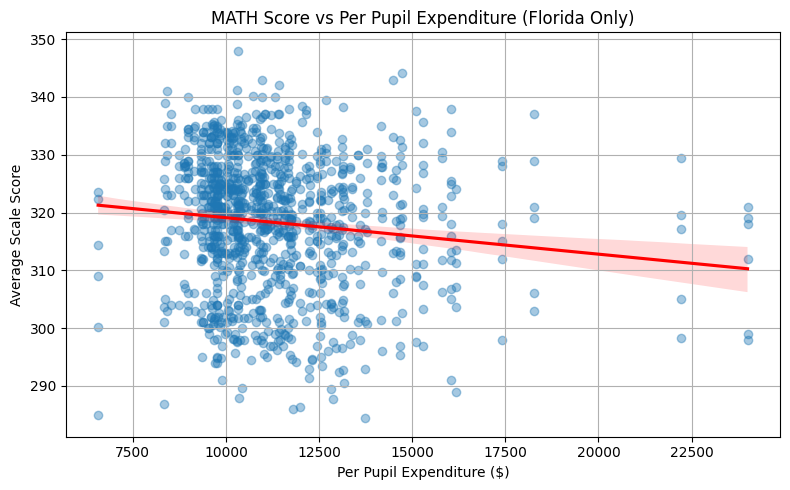


📘 Linear Regression for ELA (Florida Only, with Year & Grade Controls)
                            OLS Regression Results                            
Dep. Variable:          AvgScaleScore   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     1746.
Date:                Sat, 19 Apr 2025   Prob (F-statistic):               0.00
Time:                        03:52:22   Log-Likelihood:                -3302.8
No. Observations:                1080   AIC:                             6614.
Df Residuals:                    1076   BIC:                             6633.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

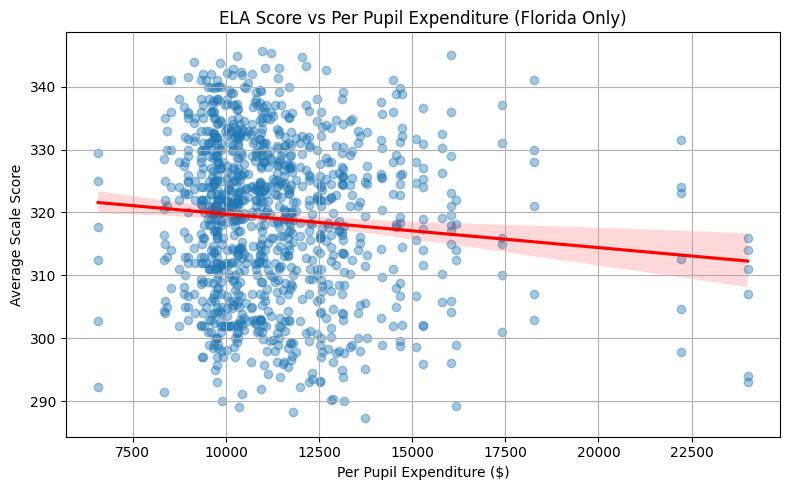

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Step 0: Filter to Florida only
florida_df = merged_df[merged_df['State'].str.strip(
).str.lower() == 'florida'].copy()

# Clean numeric columns
florida_df['Per Pupil Expenditure'] = pd.to_numeric(
    florida_df['Per Pupil Expenditure'], errors='coerce')
florida_df['AvgScaleScore'] = pd.to_numeric(
    florida_df['AvgScaleScore'], errors='coerce')
florida_df['Year_clean'] = pd.to_numeric(
    florida_df['Year_clean'], errors='coerce')

# Standardize grade level (remove 'G' prefix and convert to numeric)
florida_df['Grade_numeric'] = florida_df['GradeLevel'].str.extract(r'G(\d+)')
florida_df['Grade_numeric'] = pd.to_numeric(
    florida_df['Grade_numeric'], errors='coerce')

# Step 1: Filter for math and ela, drop nulls
reg_df = florida_df[
    (florida_df['Subject'].isin(['math', 'ela'])) &
    (florida_df['Per Pupil Expenditure'].notna()) &
    (florida_df['AvgScaleScore'].notna()) &
    (florida_df['Year_clean'].notna()) &
    (florida_df['Grade_numeric'].notna())
].copy()

# Step 2: Fit model separately for math and ela
for subject in ['math', 'ela']:
    print(
        f"\n📘 Linear Regression for {subject.upper()} (Florida Only, with Year & Grade Controls)")

    subj_df = reg_df[reg_df['Subject'] == subject].copy()

    X = subj_df[['Per Pupil Expenditure', 'Year_clean', 'Grade_numeric']]
    y = subj_df['AvgScaleScore']

    # Add constant
    X = sm.add_constant(X)

    # Fit model
    model = sm.OLS(y, X).fit()
    print(model.summary())

    # Step 3: Plot unadjusted raw scatter + trend line
    plt.figure(figsize=(8, 5))
    sns.regplot(
        data=subj_df,
        x='Per Pupil Expenditure',
        y='AvgScaleScore',
        line_kws={'color': 'red'},
        scatter_kws={'alpha': 0.4}
    )
    plt.title(f'{subject.upper()} Score vs Per Pupil Expenditure (Florida Only)')
    plt.xlabel('Per Pupil Expenditure ($)')
    plt.ylabel('Average Scale Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [95]:
merged_df['State'].unique()

array(['Indiana', 'Arizona', 'Florida', 'Hawaii'], dtype=object)

In [ ]:
print("Total merged rows:", len(merged_df))
print("Subject filter:", merged_df['Subject'].isin(['math', 'ela']).sum())
print("With Per Pupil Expenditure:",
      merged_df['Per Pupil Expenditure'].notna().sum())
print("With AvgScaleScore:", merged_df['AvgScaleScore'].notna().sum())
print("With State:", merged_df['State'].notna().sum())
print("With Year:", merged_df['Year_clean'].notna().sum())

# Combine them all to see how many survive together
combo = merged_df[
    (merged_df['Subject'].isin(['math', 'ela'])) &
    (merged_df['Per Pupil Expenditure'].notna()) &
    (merged_df['AvgScaleScore'].notna()) &
    (merged_df['State'].notna()) &
    (merged_df['Year'].notna())
]
print("Final rows after all filters:", len(combo))

Total merged rows: 41536
Subject filter: 41536
With Per Pupil Expenditure: 27304
With AvgScaleScore: 3789
With State: 41536
With Year: 41536
Final rows after all filters: 2158


In [ ]:
print("🔍 Raw state counts (pre-filter):")
print(merged_df['State'].value_counts())

print("\n🔍 State counts with all required columns non-null:")
subset_mask = (
    merged_df['Per Pupil Expenditure'].notna() &
    merged_df['AvgScaleScore'].notna() &
    merged_df['State'].notna() &
    merged_df['Year'].notna()
)
print(merged_df[subset_mask]['State'].value_counts())

🔍 Raw state counts (pre-filter):
State
Arizona    22007
Indiana    15644
Florida     3789
Hawaii        96
Name: count, dtype: int64

🔍 State counts with all required columns non-null:
State
Arizona    14498
Indiana    10576
Florida     2158
Hawaii        72
Name: count, dtype: int64


In [220]:
print("📊 Finance data availability before merge:")
print(df1['Agency ID - NCES Assigned [District] Latest available year'].nunique())
print(df1['State Name [District] Latest available year'].value_counts())

📊 Finance data availability before merge:
645
State Name [District] Latest available year
Arizona    4010
Indiana    2040
Florida     390
Hawaii       10
Name: count, dtype: int64


In [221]:
print("Missing PPE by state:")
missing_ppe = merged_df[merged_df['Per Pupil Expenditure'].isna()]
print(missing_ppe['State'].value_counts())

Missing PPE by state:
State
Arizona    47251
Indiana    34007
Florida     5658
Hawaii        24
Name: count, dtype: int64


In [222]:
print(merged_df['Year'].unique())
print(merged_df['State'].unique())
print(merged_df['Subject'].unique())

['2022-23' nan '2021-22' '2020-21' '2018-19' '2023-24' '2017-18' '2015-16'
 '2016-17' '2014-15']
['Indiana' 'Arizona' 'Florida' 'Hawaii']
['ela' 'math']


In [223]:
print("Non-null AvgScaleScore in combined_df by state:")
print(combined_df[combined_df['AvgScaleScore'].notna()]
      ['State'].value_counts())
print(merged_df[merged_df['AvgScaleScore'].notna()]['State'].value_counts())

Non-null AvgScaleScore in combined_df by state:
State
Florida    7887
Name: count, dtype: int64
State
Florida    7887
Name: count, dtype: int64
